In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Urduhack
!pip install python-bidi
!pip install arabic_reshaper
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.3 MB/s 
     |████████████████████████████████| 3.4 MB 35.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud 
from bidi.algorithm import get_display
from arabic_reshaper import ArabicReshaper
import urduhack
import re
urduhack.download()
plt.rcParams["figure.figsize"] = (5,5)
plt.style.use('seaborn')
sns.set()
sns.set_style("darkgrid")
sns.set_theme()

98304/89078 [=================================] - 0s 0us/step


In [4]:
def removeSpace(string):
  """
  Method for removal of un-necessary white spaces from urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.preprocessing.normalize_whitespace(string)

def removePunctuation(string):
  """
  Method for removal of punctuations from urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.preprocessing.remove_punctuation(string)

def removeAccents(string):
  """
  Method for removal of punctuations from urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.preprocessing.remove_accents(string)

def removeNumber(string):
  """
  Method for removal of numbers from urdu text
  Paramters:
        string: sentence in the form of string
  """
  string = urduhack.preprocessing.replace_phone_numbers(string)
  return urduhack.preprocessing.replace_numbers(string)

def removeURL(string):
  """
  Method for removal of urls from urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.preprocessing.replace_urls(string)

def removeAlphabets(string):
  """
  Method for removal of English alphabets from urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.preprocessing.remove_english_alphabets(string)

def Normalize(string):
  """
  Method for normalization urdu text
  Paramters:
        string: sentence in the form of string
  """
  return urduhack.normalization.normalize(string)

def normalize_alif_madaa(string):
    line = re.sub(u"آ", "آ", string)
    return line

def normalize_kaaf(string):
    line = re.sub(u"ك", "ک", string)
    return line

def preprocess(strings):
  """
  Method for pre-processing urdu text
  Paramters:
        string: sentence in the form of string
  """
  strings = normalize_alif_madaa(strings)
  strings = normalize_kaaf(strings)
  strings = Normalize(strings)
  strings = removeAlphabets(strings)
  strings = removePunctuation(strings)
  strings = removeAccents(strings)
  strings = removeNumber(strings)
  strings = removeSpace(strings)
  return strings

In [44]:
def Create_WordCloud(text: str, save_pth="./WordCloud.png", font="./NotoNaskhArabic-Regular.ttf"):
    """
    Method to create a word cloud from given data
    Parameters:
          text: text data to make word cloud from
          save_pth: path to save the wordcloud
          font: font for words 
    """
    configuration = {
        "language": "Urdu"
    }
    reshaper = ArabicReshaper(configuration=configuration)

    text = reshaper.reshape(text)
    text = get_display(text)

    x, y = np.ogrid[:1200, :1200]
    mask = (x - 600) ** 2 + (y - 600) ** 2 > 610 ** 2
    mask = 255 * mask.astype(int)
    wc = WordCloud(max_font_size=50, width=2048, height=1080, mask=mask, background_color="white", repeat=True, font_path=font)
    wc.generate(text)

    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    wc.to_file(save_pth)

##Embeddings

In [ ]:
class Embeddings():
  """
  Class to create Word Embeddings from data
  """
  def __init__(self, sentences, size=100, window=5, epochs=25, min_count=2, embedding_type="w2v", skip_gram=0):
    """
    Arguments:
          sentences: data to create embeddings from
          size: embedding size
          window: window to select data
          epochs: number of epochs to train the model
          min_count: min count for words to include
          embedding_type: model for creating embedding "w2v" for word2vec model and "fast_text" for FastText model
          skip_gram: 0 or 1 either train model using skipgram or CBOW
    """
    self.SIZE = size
    self.WINDOW = window
    self.EPOCH = epochs
    self.MIN_COUNT = min_count
    self.TYPE = embedding_type
    self.SKIP_GRAM = skip_gram
    self.DOCUMENTS = [_text.split(" ") for _text in sentences]       

  def Model(self):
    """
    Method to Instantiate the model
    """
    if self.TYPE == "w2v":
        self.MODEL = gensim.models.word2vec.Word2Vec(size=self.SIZE, window=self.WINDOW, min_count=self.MIN_COUNT, workers=8, sg=self.SKIP_GRAM)  
    elif self.TYPE == "fast_text":
        self.MODEL = gensim.models.fasttext.FastText(size=self.SIZE, window=self.WINDOW, min_count=self.MIN_COUNT, workers=8, sg=self.SKIP_GRAM)
    else:
        raise Exception('Embedding Model not valid')

  def BuildVocab(self):
    """
    Method to build the vocabulary for the model
    """
    self.MODEL.build_vocab(self.DOCUMENTS)

  def VocabSize(self):
    """
    Method to get size of the vocabulary
    """
    words = len(self.MODEL.wv.vocab.keys())
    return words

  def Train(self):
    """
    Method to train the model
    """
    self.MODEL.train(self.DOCUMENTS, total_examples=len(self.MODEL.wv.vocab.keys()), epochs=self.EPOCH)

  def GetModel(self, load=False, path="./"):
    """
    Method to get trained model
    Parameters:
          load: True if want to load existing model
          path: path of the model
    """
    if load: self.MODEL = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    else:
      self.Model()
      self.BuildVocab()
      self.Train()

  def LoadPretrainedModel(self, path='./model.bin', binary=True):
    """
    Method to load pre-trained model
    Parameters:
          path: path to load model from
          binary: whether binary format or not 
    """
    if binary: self.pre_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=binary)
    else: self.pre_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=binary)
 
  def GetUpdatedModel(self, path='./model.bin'):
    """
    Method to update the already existing models vocabulary with new vocabulary and train the model
    Parameters:
          path: path to load model from
    """
    self.Model()
    self.BuildVocab()
    self.MODEL.build_vocab([list(self.pre_model.vocab.keys())], update=True)
    if self.TYPE=="w2v": self.MODEL.intersect_word2vec_format(path, binary=True)
    self.Train()

  def GetEmbeddingMatrix(self):
    """
    Method to get embedding matrix
    """
    return self.MODEL.wv.vectors

  def SaveModel(self, path="./", filename='model.bin'):
    """
    Method to save the model
    Parameters:
          path: path to save model to
          filename: filename and format to save file in
    """    
    self.MODEL.wv.save_word2vec_format(path+filename, binary=True)

In [ ]:
class Tokenization():
  """
  Class to create tokens of the given input data
  """
  def __init__(self, data, max_length=300, pad=True):
      """
      Arguments:
            data: input data for tokenization
            max_length: max length to make all inputs of same size
            pad: whether to pad the data with zeros or not
      """
      self.Data = data
      self.Sequence_length = max_length
      self.Tokenizer = Tokenizer()
      self.Pad = pad

  def Tokenize(self):
      """
      Method returns tokenized the data
      """
      self.Tokenizer.fit_on_texts(self.Data)
      if self.Pad: return pad_sequences(self.Tokenizer.texts_to_sequences(self.Data), maxlen=self.Sequence_length)
      else: return self.Tokenizer.texts_to_sequences(self.Data)

  def SaveTokenizer(self, path="./tokenizer.pickle"):
      """
      Method to save the tokenizer
      Parameters:
            path: path to save tokenizer to
      """
      with open(path, 'wb') as handle:
          pickle.dump(self.Tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  def LoadTokenizer(self, path="./tokenizer.pickle"):
      """
      Method to load the tokenizer
      Parameters:
            path: path to load tokenizer from
      """
      with open(path, 'rb') as handle:
          self.Tokenizer = pickle.load(handle)

##Check

In [7]:
df = pd.read_excel("./drive/MyDrive/Urdu-Toxic-Comments-Thesis/Data/Normalized_Data.xlsx")
df['clean'] = df['clean'].apply(str)
df.head()

,Unnamed: 0,level_0,index,Comment,Toxic,Urdu,clean,length
0,0.0,0.0,0.0,Jo ata hy nea treqa batata hy kia lul mara how...,1.0,جو آتا ہے نیا طریقہ بتاتا ہے کیا لل مارا ہوا ہے,جو آتا ہے نیا طریقہ بتاتا ہے کیا لل مارا ہوا ہے,12.0
1,1.0,1.0,1.0,Lakh lanat ho terie shakal par... Aik chez dik...,1.0,لاکھ لعنت ہو تیری شکل پر . . . ایک چیز دکھانے...,لاکھ لعنت ہو تیری شکل پر ایک چیز دکھانے کے لئے...,19.0
2,2.0,2.0,2.0,Bakwaas bevqoof bna rahay ho logon ko,1.0,بکواس بیوقوف بنا رہے ہو لوگوں کو,بکواس بیوقوف بنا رہے ہو لوگوں کو,7.0
3,3.0,3.0,3.0,O lanti das bhi de,1.0,او لعنتی دس بھی دے,او لعنتی دس بھی دے,5.0
4,4.0,4.0,4.0,lun b gold ka hona chahiy tha,1.0,لن بھی گولڈ کا ہونا چاہئے تھا,لن بھی گولڈ کا ہونا چاہئے تھا,7.0


In [8]:
tox = df[df.Toxic == 1]
ntox = df[df.Toxic == 0]
len(tox), len(ntox)

(12812, 58056)

In [9]:
max(df[df.Toxic == 1]['length']), max(df[df.Toxic == 0]['length'])

(141.0, 199.0)

In [10]:
np.mean(df[df.Toxic == 1]['length']), np.mean(df[df.Toxic == 0]['length']), np.mean(df.length)

(14.24344364658133, 21.241904368196224, 19.97667494496811)

In [11]:
np.std(df[df.Toxic == 1]['length']), np.std(df[df.Toxic == 0]['length']), np.std(df.length)

(15.158501990104702, 19.03050442801889, 18.587130179345756)

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ntox.clean)
print(ntox.length.sum())
vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)

1233220.0
Total words 47209


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tox.clean)
print(tox.length.sum())
vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)

182487.0
Total words 12567


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.clean)
print(df.length.sum())
vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)

1415707.0
Total words 51707


## Pre-process dataset and create embeddings and tokens from it

In [17]:
DATA_PTH = "./drive/MyDrive/Urdu-Toxic-Comments-Thesis/Data/"

In [18]:
sheet1 = pd.read_excel(DATA_PTH + 'RUT_UT_Comments.xlsx', sheet_name="Sheet1")
print(f"Length of Toxic DataFrame is {len(sheet1)}")
sheet1['len'] = sheet1['Urdu'].apply(lambda x: len(x.split(" ")))
sheet1.sample(5)

Length of Toxic DataFrame is 13097


,Comment,Toxic,Urdu,len
2331,Sarm kar re sudhir chaudhri sale,1,شرم کر رے سدھیر چودھری سالے,8
3808,Lanat nida pe,1,لعنت ندا پہ,5
7082,hut dalllllla ki olaaaad.............. Or phir...,1,ہٹ دلا کی اولاد . . . . . . . . . . . . . . ا...,135
2527,Budhi heen shidhu teri khopadi mai budhi nai h...,1,بدھی ہیں سدھو تیری کھوپڑی میں بدھی نہیں ہے اُ...,19
63,Uloo Ki Pati,1,الو کی پٹھی,5


In [19]:
max(sheet1.len), np.mean(sheet1.len), np.std(sheet1.len)

(197, 17.283805451630144, 17.00272401392607)

In [20]:
sheet2 = pd.read_excel(DATA_PTH+'RUT_UT_Comments.xlsx', sheet_name="Sheet2")
print(f"Length of Non Toxic DataFrame is {len(sheet2)}")
sheet2['len'] = sheet2['Urdu'].apply(lambda x: len(x.split(" ")))
sheet2.sample(5)

Length of Non Toxic DataFrame is 59674


,Comment,Toxic,Urdu,len
33436,rozay ko agar aap agli raat ke andar daakhil k...,0,روزے کو اگر آپ اگلی رات کے اندر داخل کر دیں گ...,34
51774,Gham ka baadal jo chhaaye to hum muskuraate ra...,0,غم کا بادل جو چھائے تو ہم مسکراتے رہے اپنی آن...,61
21961,Kuch bhi sansanikheez baatein bolte rehte hain...,0,کچھ بھی سنسنی خیز باتیں بولتے رہتے ہیں یہ صاح...,23
5916,http://theworkpayment.com/?userid=20396,0,http://theworkpayment.com/?userid=20396,3
30144,"Aao Hum Nikah-e-Ishq Ker Len,,Tum Jahez Me Apn...",0,آؤ ہم نکاح عشق کر لیں ، ، تم جہیز میں اپنے سا...,33


In [21]:
max(sheet2.len), np.mean(sheet2.len), np.std(sheet2.len)

(230, 24.239233166873344, 20.384477955150096)

In [22]:
df = pd.concat([sheet1, sheet2])
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
print(f"Length of All DataFrame is {len(df)}")
df.sample(5)

Length of All DataFrame is 72771


,Comment,Toxic,Urdu,len
30501,Aaj kal wo mukhtalif channels par commentary a...,0,آج کل وہ مختلف چینلز پر کمنٹری اور آئی پی ایل...,25
1942,Pagal jai na hoye .. reporter ka hath e le k b...,1,پاگل جئی نا ہوئے . . رپورٹو کا ہاتھ لے کے بیٹ...,15
71297,Hyderabad: Secunderabad contentment board (SCB...,0,حیدرآباد : سکندراباد کنٹنٹمنٹ بورڈ ( ایس سی ب...,64
29750,Is duniya mein bohat se log jaah o mansab ke p...,0,اس دنیا میں بہت سے لوگ جاہ و منصب کے پیچھے بھ...,41
61531,Junoobi Korea ke senior mazakraatkar aur wizar...,0,جنوبی کوریا کے سینیر مذاکرات کار اور وزارت دف...,49


In [23]:
max(df.len), np.mean(df.len), np.std(df.len)

(230, 22.987426309931156, 19.99779209449029)

In [24]:
N = df[df.Toxic == 0]
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(N.Urdu)
print(N.len.sum())
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

1446452
Total words 49510


In [25]:
T = df[df.Toxic == 1]
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(T.Urdu)
print(T.len.sum())
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

226366
Total words 13203


In [26]:
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Urdu)
print(df.len.sum())
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

1672818
Total words 54477


In [27]:
print(df[df['Urdu'].isna() == True])

Empty DataFrame
Columns: [Comment, Toxic, Urdu, len]
Index: []


In [ ]:
# df.drop(index=18556, axis=1, inplace=True)

In [28]:
# Apply Preprocessing Functions
df['clean'] = df['Urdu'].apply(lambda x: preprocess(x))

In [29]:
df.sample(5)

,Comment,Toxic,Urdu,len,clean
28788,Hn g bht,0,ہاں جی بہت,5,ہاں جی بہت
51062,saddar nasheen riyasti Haj Committee janab Moh...,0,صدر نشین ریاستی حج کمیٹی جناب محمد ماسیح للہ ...,27,صدر نشین ریاستی حج کمیٹی جناب محمد ماسیح للہ خ...
69458,Kuchi kuchi rakkamma paas aayi na\nEk achchhi ...,0,کوچی کوچی راکاما پاس آئی نا ایک اچھی اچھی گڑی...,22,کوچی کوچی راکاما پاس آئی نا ایک اچھی اچھی گڑیا...
51349,kachre ko aag laganay ke baad agar usay munasi...,0,کچرے کو آگ لگانے کے بعد اگر اسے مناسب انداز م...,33,کچرے کو آگ لگانے کے بعد اگر اسے مناسب انداز می...
45177,Constitution wagera parho phir baat karo,0,کانسٹیٹیوشن وغیرہ پڑھو پھر بات کرو,8,کانسٹیٹیوشن وغیرہ پڑھو پھر بات کرو


In [30]:
df.drop(df[df['clean'] == ""].index, inplace=True)
df.reset_index(inplace=True)

In [31]:
df.drop(df[df['clean'].duplicated()].index, inplace=True)
df.reset_index(inplace=True)
len(df)

70868

In [32]:
print(df[df['clean']==""])
idx = df[df['clean']==""].index.values
# df.drop(index=idx, axis=0, inplace=True)
print(df[df['clean']==""])

Empty DataFrame
Columns: [level_0, index, Comment, Toxic, Urdu, len, clean]
Index: []
Empty DataFrame
Columns: [level_0, index, Comment, Toxic, Urdu, len, clean]
Index: []


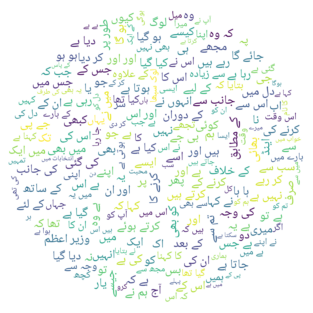

In [45]:
Ntox = " ".join(df['Urdu'][df['Toxic']==0])
Create_WordCloud(text=Ntox, save_pth="./"+"NonToxic.jpeg", font=DATA_PTH+"NotoNaskhArabic-Regular.ttf")

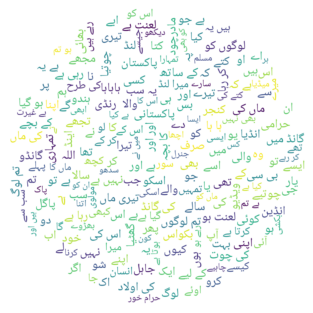

In [46]:
tox = " ".join(df['Urdu'][df['Toxic']==1])
Create_WordCloud(text=tox, save_pth="./"+"Toxic.jpeg", font=DATA_PTH+"NotoNaskhArabic-Regular.ttf")

In [ ]:
len(df)

70868

In [ ]:
import spacy
nlp = spacy.blank('ur')

In [ ]:
df['length'] = df['clean'].apply(lambda x: len([wrd for wrd in nlp(x)]))
df.sample(5)

,level_0,index,Comment,Toxic,Urdu,clean,length
16470,17068,17090,Love all of your work,0,لو آل آف یور ورک,لو آل آف یور ورک,5
40389,41833,41922,"Meri pagal mohabbat tumhein yaad aye gi,Jab ch...",0,میری پاگل محبت تمہیں یاد آئے گی ، جب چند ستار...,میری پاگل محبت تمہیں یاد آئے گی جب چند ستارے چ...,41
13411,13720,13720,Ishq Rasool pak (s.a.w) ma ana to theek ha mag...,0,عشق رسول پاک ( صلی اللہ علیہ وسلم ) میں آنا ت...,عشق رسول پاک صلی اللہ علیہ وسلم میں آنا تو ٹھی...,54
49870,51476,51578,ab police yeh pata laganay ki koshish kar rahi...,0,اب پولیس یہ پتہ لگانے کی کوشش کر رہی ہے کہ قت...,اب پولیس یہ پتہ لگانے کی کوشش کر رہی ہے کہ قتل...,24
19655,20501,20574,Junaid Baloch,0,جنید بلوچ,جنید بلوچ,2


In [ ]:
df['length'].max()

199

In [ ]:
df.to_excel(DATA_PTH+'/Normalized_Data.xlsx')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


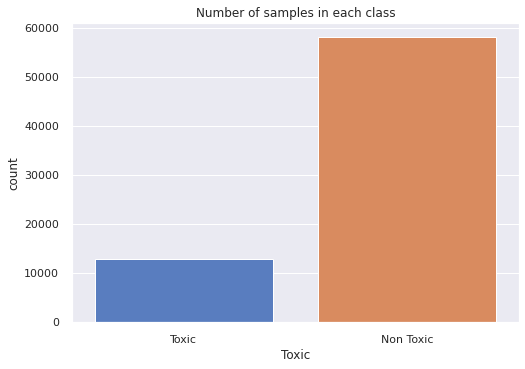

In [ ]:
plt.title("Number of samples in each class")
sns_plot = sns.countplot(df['Toxic'].apply(lambda x: 'Toxic' if x == 1 else 'Non Toxic'), palette='muted',)

In [ ]:
fig = sns_plot.get_figure()
fig.savefig(DATA_PTH+"LABELS.png")

Length 14174


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


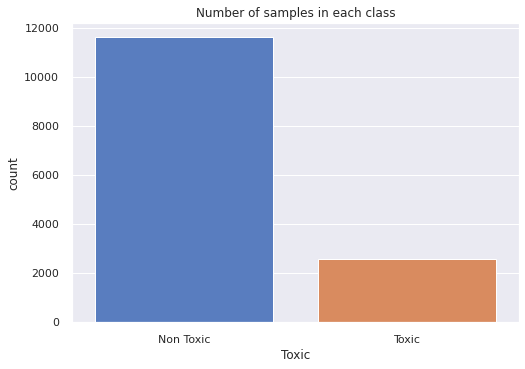

In [ ]:
df = pd.read_excel("./drive/MyDrive/Urdu-Toxic-Comments-Thesis/Data/Testing.xlsx")
print("Length", len(df))
plt.title("Number of samples in each class")
sns_plot = sns.countplot(df['Toxic'].apply(lambda x: 'Toxic' if x == 1 else 'Non Toxic'), palette='muted',)
fig = sns_plot.get_figure()
fig.savefig("./drive/MyDrive/Urdu-Toxic-Comments-Thesis/"+"test.png")